# Plotting GRIT rivers by name

In [20]:
import os
import numpy as np
from tqdm import tqdm
import pandas as pd
import geopandas as gpd
from matplotlib import pyplot as plt
import cartopy.crs as ccrs

## Inputs

In [2]:
RIVER_NAME = "Paraná"
segments = "GRITv1.0_segments_SA_EPSG8857.gpkg"
catchments = "GRITv1.0_component_catchments_GLOBAL_EPSG8857.gpkg"

### Download data if needed

In [3]:
! for f in component_catchments_GLOBAL segments_SA ; do \
  file=GRITv1.0_${f}_EPSG8857.gpkg; test -f $file || {wget https://zenodo.org/records/17435232/files/$file.zip \
  && unzip $file}; done

## Read input data

In [4]:
river_segments = gpd.read_file(segments, where=f"name like '%{RIVER_NAME}%'", layer="lines").set_index("global_id")
comp_catchments = gpd.read_file(catchments).set_index("global_id")

Find the catchment ID of the river by most common, as it's not guaranteed that river names have a unique catchment.

In [5]:
catch_id = river_segments.catchment_id.mode()[0]
catchment_segments = gpd.read_file(segments, where=f"catchment_id={catch_id} AND drainage_area_out > 500", layer="lines").set_index("global_id")
river_catchment = comp_catchments.loc[[catch_id]]

## A quick catchment map

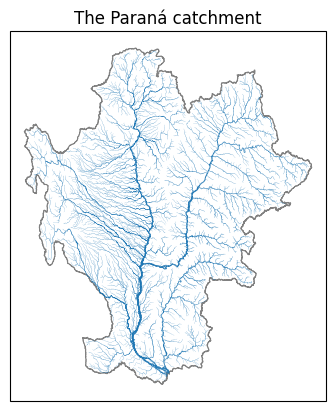

In [6]:
fig, ax = plt.subplots(1, 1, subplot_kw={"projection": ccrs.EqualEarth()})
catchment_segments.plot(linewidth=0.01*catchment_segments["drainage_area_out"]**0.32, ax=ax)
river_catchment.plot(linewidth=0.8, edgecolor="0.5", facecolor="none", ax=ax)
ttl = ax.set_title(f"The {RIVER_NAME} catchment")

## A more complete catchment map with major river names

In [7]:
from mpl_toolkits.axes_grid1.inset_locator import inset_axes
from cartopy.mpl.geoaxes import GeoAxes
from mpl_toolkits.axes_grid1.inset_locator import inset_axes, AnchoredSizeLocator
import cartopy.feature as cfeature
from matplotlib.lines import Line2D
from cartopy.mpl.gridliner import LONGITUDE_FORMATTER, LATITUDE_FORMATTER

### Finding the major river names and labelling
Check the river names we found in the catchment and possibly refine our search term `RIVER_NAME`. The sum of ranks of the drainage area, length and width is a good indicator of importance of the names. Also select our major tributaries.

In [13]:
names_agg = catchment_segments.groupby("name").agg({"drainage_area_out": "max", "length": "sum", "width_adjusted": "mean"})
major_rivers = ["Río Paraná", "Uruguay River", "Paraguay", "Paranaíba River", "Río Pilcomayo", "Río Bermejo", "Río Salado",
                "Rio Paranapanema", "Iguazu River", "Rio Grande", "Rio Cuiabá"]
# nudge labels slightly in x, y points if needed, leave blank at first
label_nudges = {"Paraguay": (0, 30), "Paranaíba River": (0, 15), "Río Salado": (-20, +5)}
# alternative automatic selection, good for a first check
#major_rivers = names_agg.rank().sum(axis=1).sort_values(ascending=False).index[:20]
names_agg.rank().sum(axis=1).sort_values(ascending=False).head(10)

name
Río Paraná          2772.0
Uruguay River       2745.0
Paraguay            2710.0
Paranaíba River     2700.0
Rio Paraná          2698.0
Parana River        2693.0
Rio Grande          2688.0
Rio Paranapanema    2662.0
Río Negro           2651.0
Paraguay River      2606.0
dtype: float64

Functions to get mean line orientation and labling of river names:

In [14]:
def mean_line_orientation(gdf):
    angles, lengths = [], []
    for line in gdf.geometry:
        coords = np.array(line.coords)
        dx, dy = np.diff(coords[:,0]), np.diff(coords[:,1])
        seg_angles = np.arctan2(dy, dx)
        seg_lengths = np.hypot(dx, dy)
        angles.append(seg_angles)
        lengths.append(seg_lengths)

    angles = np.concatenate(angles)
    lengths = np.concatenate(lengths)
    x = np.sum(np.cos(angles) * lengths) / np.sum(lengths)
    y = np.sum(np.sin(angles) * lengths) / np.sum(lengths)
    mean_angle_rad = np.arctan2(y, x)
    mean_angle_deg = (np.degrees(mean_angle_rad) + 180) % 360 - 180
    mean_angle_deg -= 180 if mean_angle_deg > 90 else 0
    mean_angle_deg += 180 if mean_angle_deg < -90 else 0
    return mean_angle_deg

def label_river(ax, r):
    rsegs = catchment_segments[catchment_segments.name == r]
    midpoints = rsegs.geometry.apply(lambda x: x.interpolate(0.5, normalized=True))
    x = np.average(midpoints.x, weights=rsegs.geometry.length)
    y = np.average(midpoints.y, weights=rsegs.geometry.length)
    ax.annotate(r, xy=(x, y), xytext=label_nudges[r] if r in label_nudges else (0, 0), rotation=mean_line_orientation(rsegs), color="w", fontweight='bold', **label_kw)
    ax.annotate(r, xy=(x, y), xytext=label_nudges[r] if r in label_nudges else (0, 0), rotation=mean_line_orientation(rsegs), color='0.15', **label_kw)


### The actual plot

In [15]:
subplot_kw = dict(
    subplot_kw={"projection": ccrs.EqualEarth()},
    constrained_layout=True,
    figsize=(7, 7),
)
catch_cent = river_catchment.centroid.to_crs(epsg=4326).iloc[0]
inset_proj = ccrs.Orthographic(catch_cent.x, catch_cent.y)
inset_kw = dict(
    width="39%",
    height="30%",
    loc="lower right",
    borderpad=0,
    axes_class=GeoAxes,
    axes_kwargs={"projection": inset_proj},
)
label_kw = dict(textcoords='offset points', rotation_mode='anchor', fontsize=8, ha='center', va='center')
local_lw = 0.015*catchment_segments["drainage_area_out"]**0.32

Filter segments that have got significant bifurcation budgets:

In [16]:
bifurcated_rivers = catchment_segments[catchment_segments.bifurcation_balance_out.abs() > 0.1]
bif_color = "#B22222"

Put it all together in a figure.

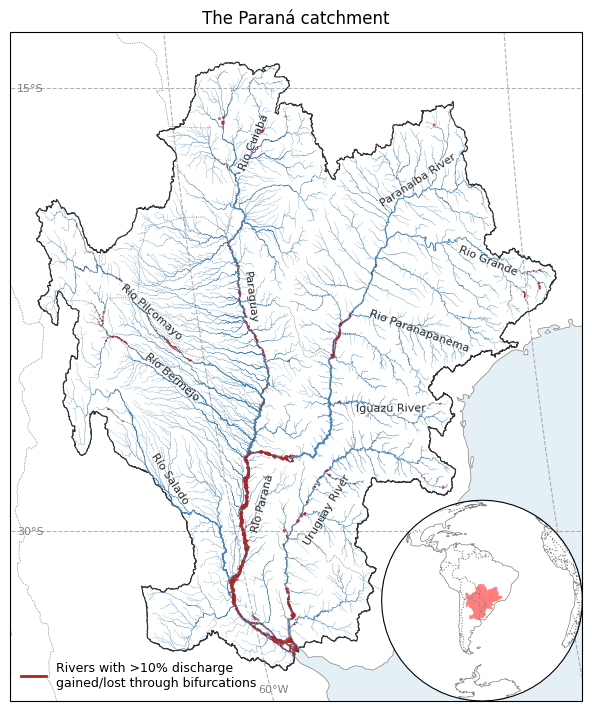

In [19]:
# figure/axes setup
fig, axl = plt.subplots(1, 1, **subplot_kw)
axr = inset_axes(axl, **inset_kw)

# catchment
catchment_segments.plot(linewidth=local_lw, color='#4682b4', ax=axl)
river_catchment.plot(linewidth=0.8, edgecolor="0.2", facecolor="none", ax=axl)
axl.coastlines(linewidth=0.5, color="0.5")
axl.add_feature(cfeature.BORDERS, linestyle=':', linewidth=0.5, edgecolor="0.3")
axl.set_title(f"The {RIVER_NAME} catchment")
# names
for r in major_rivers:
    label_river(axl, r)
# bifurcated rivers highlight and legend
bifurcated_rivers.plot(linewidth=local_lw*2, alpha=0.8, color=bif_color, ax=axl)
axl.legend(
    handles=[Line2D([0], [0], color=bif_color, lw=2, label="Rivers with >10% discharge \ngained/lost through bifurcations")],
    loc="lower left",
    frameon=False,
    fontsize=9,
)
# gridlines
gl = axl.gridlines(
    crs=ccrs.PlateCarree(),
    draw_labels=True,
    linewidth=0.8,
    color='gray',
    alpha=0.6,
    linestyle='--'
)
gl.xformatter = LONGITUDE_FORMATTER
gl.yformatter = LATITUDE_FORMATTER
gl.top_labels = False
gl.right_labels = False
gl.xlabel_style = {'size': 8, 'color': 'gray'}
gl.ylabel_style = {'size': 8, 'color': 'gray'}
gl.xlocator = plt.FixedLocator(np.arange(-180, 181, 15))
gl.ylocator = plt.FixedLocator(np.arange(-90, 91, 15))
gl.xpadding = -5
gl.ypadding = -5

# global overview
axr.set_global()
axr.coastlines(linewidth=0.5, color="0.5")
river_catchment.to_crs(inset_proj).plot(linewidth=0.8, edgecolor="none", facecolor="r", alpha=0.5, ax=axr)
axl.add_feature(cfeature.OCEAN, facecolor='#a6cee3', alpha=0.3)
# bring axes back to same level after aspect change
apos, inpos = axl.get_position(), axr.get_position()
axr.set_axes_locator(None)  # disables internal locator
axr.set_position([apos.x0+apos.width-inpos.width, apos.y0, inpos.width, inpos.height])
brdrs = axr.add_feature(cfeature.BORDERS, linestyle=':', linewidth=0.8, edgecolor="0.5")